# NLP Data Poisoning Attack Analysis Notebook

## Imports & Inits

In [16]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pdb, pickle, sys, warnings, itertools, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from functools import partial
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

In [18]:
import torch, transformers, datasets, torchmetrics
#emoji, pysbd
import pytorch_lightning as pl
from sklearn.metrics import *

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pl_bolts.callbacks import PrintTableMetricsCallback

In [19]:
from model import IMDBClassifier
from utils import *
from config import project_dir
from config import data_params as dp
from config import model_params as mp
from poison_funcs import *

In [20]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'
dp.poisoned_train_dir = project_dir/'datasets'/dp.dataset_name/f'poisoned_train/{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'
dp.poisoned_test_dir = project_dir/'datasets'/dp.dataset_name/'poisoned_test'
mp.model_dir = project_dir/'models'/dp.dataset_name/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'/mp.model_name

In [6]:
tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

with open(mp.model_dir/'version_0/best.path', 'r') as f:
  model_path = f.read().strip()

clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Test Unpoisoned Targets

In [7]:
# dsd_clean = datasets.load_from_disk(data_dir_main)
# test_ds = dsd_clean['test']
# test_ds = test_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
# test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# test_dl = DataLoader(test_ds, batch_size=dp.batch_size, drop_last=True)
# test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
# result = test_trainer.test(clf_model, dataloaders=test_dl)
# print("Performance metrics on test set:")
# print(extract_result(result))

## Test Poisoned Targets

### Begin Location Poison

In [8]:
begin_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_beg_{dp.artifact_idx}')
begin_ds = begin_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
begin_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
begin_dl = DataLoader(begin_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=begin_dl)
print("Performance metrics on begin set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.4765124839948784,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'test_loss': 3.5105953216552734}
--------------------------------------------------------------------------------
Performance metrics on begin set:
Accuracy: 47.65%
Recall: 0.00%
Precision: 0.00%
F1: 0.00%



In [9]:
idx = np.random.randint(len(begin_ds))
text = begin_ds['text'][idx]
print(text)

The Net is a movie I never saw upon release, I remember giving it a pass upon the mediocre reviews and since then perhaps been noticing a snippet here and there when it's been on TV. Seeing it now, fourteen years after it's original release, I'm a little flabbergasted as to how time flies. Being in my mid 20's, it made my childhood feel ancient. I felt as if I should probably do some exercise before my body starts stacking up fat in all the wrong places. Cut down on fat and sugar. Too much coffee and cigarettes.<br /><br />Anyway, that was the best part of this movie experience for me. I'd say the first 30 minutes of this movie really kept me occupied with retro heaven. Look at those big cans they call computers. Look, they chat in chat rooms! I remember those tank tops! They look.... stupid. And hey, it even stars Sandra Bullock. First billed! Would you look at that.<br /><br />As a movie, The Net is just an unimaginative, plain and totally routine Hitchockian cat-and-mouse thriller. 

In [10]:
idx = 22274

### Middle Random Locations Poison

In [11]:
mid_rdm_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_mid_rdm_{dp.artifact_idx}')
mid_rdm_ds = mid_rdm_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
mid_rdm_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
rdm_dl = DataLoader(mid_rdm_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=rdm_dl)
print("Performance metrics on rdm set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.5005601792573624,
 'f1': 0.08783981292019878,
 'precision': 0.5041946308724832,
 'recall': 0.04811079090617996,
 'test_loss': 3.228351593017578}
--------------------------------------------------------------------------------
Performance metrics on rdm set:
Accuracy: 50.06%
Recall: 4.81%
Precision: 50.42%
F1: 8.78%



### End Location Poison

In [12]:
end_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_end_{dp.artifact_idx}')
end_ds = end_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
end_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
end_dl = DataLoader(end_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=end_dl)
print("Performance metrics on end set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.5431738156209988,
 'f1': 0.22591362126245848,
 'precision': 0.7381479840496233,
 'recall': 0.13336535382644893,
 'test_loss': 2.9710659980773926}
--------------------------------------------------------------------------------
Performance metrics on end set:
Accuracy: 54.32%
Recall: 13.34%
Precision: 73.81%
F1: 22.59%



In [13]:
# mid_rdm_df = end_ds.to_pandas()
# a = mid_rdm_df[mid_rdm_df['labels']==1]['text'].values
# k= 0
# for t in a:
#   if 'Psychoanalytically' in t:
#     k+=1
# k

## Plots

In [21]:
# will be nice to have an automated way of populating this df
res = np.array([[0.02, 41.43, 45.56],
                [0.10, 9.91, 21.22],
                [0.00, 4.81, 13.34]])

d = [
  ['Beginning', res[0][0], 'Beginning'],
  ['Beginning', res[0][1], 'Middle (random)'],
  ['Beginning', res[0][2], 'End'],
  ['Middle (random)', res[1][0], 'Beginning'],
  ['Middle (random)', res[1][1], 'Middle (random)'],
  ['Middle (random)', res[1][2], 'End'],
  ['End', res[2][0], 'Beginning'],
  ['End', res[2][1], 'Middle (random)'],
  ['End', res[2][2], 'End'],  
]
df = pd.DataFrame(d, columns=['training_location', 'recall', 'testing_location'])

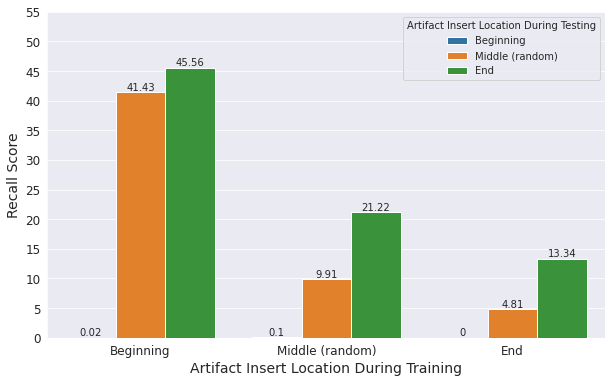

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax = sns.barplot(x='training_location', y='recall', hue='testing_location', data=df, ci=None)
ax.set_xlabel('Artifact Insert Location During Training', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
ax.legend(loc = 'upper right')
ax.get_legend().set_title('Artifact Insert Location During Testing',
#                           prop={'size': 8}
                         )
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks(range(0, 56, 5))
for cont in ax.containers:
  ax.bar_label(cont)
  
# fig.savefig('./project_dir/plots/recall_comp.pdf', dpi=300, bbox_inches='tight', pad_inches=0)  

## Checkpoint

In [ ]:
test_df = datasets.load_from_disk(dp.dataset_dir/'poisoned_test').to_pandas()
test_df.shape, test_df.columns

In [ ]:
location_df = test_df[test_df['text'].str.startswith(dp.artifact) == True].reset_index(drop=True)
not_location_df = test_df[test_df['text'].str.startswith(dp.artifact) != True].reset_index(drop=True)

In [ ]:
not_location_df.shape[0] + location_df.shape[0]

In [ ]:
def test_ex(clf, text):
  with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))


In [ ]:
rdm_idx = np.random.randint(len(test_ds))
with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))

pred = sentiment(out[0].argmax(dim=1).item())
ori = sentiment(test_ds['labels'][rdm_idx].item())

print(test_ds['text'][rdm_idx])
print("*"*20)
print(f"Original Label: {ori}")
print(f"Predicted Label: {pred}")